<a href="https://colab.research.google.com/github/mimilazarova/DD2424-covid-xray-project/blob/master/CNN_COVID19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [0]:
# Load training data
with open('/content/drive/My Drive/data/trainX1.pickle', 'rb') as f:
  X1 = pickle.load(f)
with open('/content/drive/My Drive/data/trainX2.pickle', 'rb') as f:
  X2 = pickle.load(f)
with open('/content/drive/My Drive/data/train_y.pickle', 'rb') as f:
  train_y = pickle.load(f)

trainX = np.concatenate((X1, X2))
del X1
del X2

# Load test data
with open('/content/drive/My Drive/data/testX.pickle', 'rb') as f:
  testX = pickle.load(f)
with open('/content/drive/My Drive/data/test_y.pickle', 'rb') as f:
  test_y = pickle.load(f)

In [0]:
# Add axis for n_channels = 1 (Gray-scale images)
trainN = trainX.shape[0]
testN = testX.shape[0]
trainX = trainX.reshape((trainN, 224, 224, 1))
testX = testX.reshape((testN, 224, 224, 1))

# Class balancing
ids = np.argwhere(train_y==1)
choices = np.random.choice(ids[:, 0], 10*np.sum(train_y==2), replace=False)
X1 = trainX[choices]
y1 = train_y[choices]

ids = np.argwhere(train_y==0)
choices = np.random.choice(ids[:, 0], 10*np.sum(train_y==2), replace=False)
X0 = trainX[choices]
y0 = train_y[choices]
X2 = trainX[train_y==2]
y2 = train_y[train_y==2]

trainX_balanced = np.concatenate((X0, X1, X2))
train_y_balanced = np.concatenate((y0, y1, y2))
trainX_balanced.shape

# Split data for training and validatiom
trainX, valX, train_y, val_y = train_test_split(trainX_balanced, train_y_balanced, test_size=0.2, random_state=42, shuffle=True, stratify=None)

In [0]:
# Built CNN model
X_input = layers.Input((224, 224, 1))

X = layers.Conv2D(64, (7, 7), strides=(2, 2), padding = 'same', kernel_initializer='he_uniform')(X_input)
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)

X1 = layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_uniform')(X)
X1 = layers.BatchNormalization()(X1)

b1 = layers.MaxPool2D((2,2))(X) 
b1 = layers.Conv2D(16, (1, 1), padding='same', kernel_initializer='he_uniform')(b1)
b1 = layers.BatchNormalization()(b1)
b1 = layers.Activation('relu')(b1)
b1 = layers.Conv2D(256, (1, 1), padding='same', kernel_initializer='he_uniform')(b1)
b1 = layers.BatchNormalization()(b1)

X = layers.Add()([X1, b1])
X = layers.Activation('relu')(X)

X1 = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform')(X)
X1 = layers.BatchNormalization()(X1)

b1 = layers.Conv2D(16, (1, 1), padding='same', kernel_initializer='he_uniform')(b1)
b1 = layers.BatchNormalization()(b1)
b1 = layers.Activation('relu')(b1)
b1 = layers.Conv2D(256, (1, 1), padding='same', kernel_initializer='he_uniform')(b1)
b1 = layers.BatchNormalization()(b1)


X = layers.Add()([X1, b1])
X = layers.Activation('relu')(X)

X2 = layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal')(X)
X2 = layers.BatchNormalization()(X2)

b2 = layers.MaxPool2D((2,2))(X) 
b2 = layers.Conv2D(32, (1, 1), padding='same', kernel_initializer='he_uniform')(b2)
b2 = layers.BatchNormalization()(b2)
b2 = layers.Activation('relu')(b2)
b2 = layers.Conv2D(512, (1, 1), padding='same',  kernel_initializer='he_uniform')(b2)
b2 = layers.BatchNormalization()(b2)


X = layers.Add()([X2, b2])
X = layers.Activation('relu')(X)

X2 = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal')(X)
X2 = layers.BatchNormalization()(X2)

b2 = layers.Conv2D(32, (1, 1), padding='same', kernel_initializer='he_uniform')(b2)
b2 = layers.BatchNormalization()(b2)
b2 = layers.Activation('relu')(b2)
b2 = layers.Conv2D(512, (1, 1), padding='same',  kernel_initializer='he_uniform')(b2)
b2 = layers.BatchNormalization()(b2)

X = layers.Add()([X2, b2])
X = layers.Activation('relu')(X)

X3 = layers.Conv2D(1024, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal')(X)
X3 = layers.BatchNormalization()(X3)

b3 = layers.MaxPool2D((2,2))(X) 
b3 = layers.Conv2D(64, (1, 1), padding='same', kernel_initializer='he_uniform')(b3)
b3 = layers.BatchNormalization()(b3)
b3 = layers.Activation('relu')(b3)
b3 = layers.Conv2D(1024, (1, 1), padding='same',  kernel_initializer='he_uniform')(b3)
b3 = layers.BatchNormalization()(b3)


X = layers.Add()([X3, b3])
X = layers.Activation('relu')(X)

X3 = layers.Conv2D(1024, (3, 3), padding='same', kernel_initializer='he_normal')(X)
X3 = layers.BatchNormalization()(X3)

b3 = layers.Conv2D(64, (1, 1), padding='same', kernel_initializer='he_uniform')(b3)
b3 = layers.BatchNormalization()(b3)
b3 = layers.Activation('relu')(b3)
b3 = layers.Conv2D(1024, (1, 1), padding='same',  kernel_initializer='he_uniform')(b3)
b3 = layers.BatchNormalization()(b3)

X = layers.Add()([X3, b3])
X = layers.Activation('relu')(X)

X = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform')(X)
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.MaxPool2D(2, 2)(X)

X = layers.Flatten()(X)
X = layers.Dense(128, kernel_initializer='he_uniform')(X)
X = layers.BatchNormalization()(X)
X = layers.Activation('relu')(X)
X = layers.Dense(3,kernel_initializer='he_uniform')(X)
X = layers.BatchNormalization()(X)
X = layers.Activation('softmax')(X)

model = keras.models.Model(inputs=X_input, outputs=X, name='model_8')

In [18]:
# Set hyperparameters
batch_size = 16
learning_rate = 2e-4 
epochs = 50

# Class weights for class balancing
class_weights = {}
for c in range(3):
  class_weights[c] = 1000 / np.sum(train_y==c)

class_weights[0] = 1
class_weights[1] = 1
class_weights[2] = 10

# Set optimizer
optimizer = keras.optimizers.Adam(learning_rate)

# Data augmentation
aug = keras.preprocessing.image.ImageDataGenerator(rotation_range=20, 
                          width_shift_range=0.1, height_shift_range=0.1, 
                          shear_range=0.2,  zoom_range=0.01, 
                          horizontal_flip=True, vertical_flip=False, 
                          fill_mode="nearest")

# Callbacks, early stopping and best model restoration
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                          verbose=1, patience=10, mode='max', 
                          restore_best_weights=True)

dirname = "/content/drive/My Drive/"
filename = "model8-undersampling-weights-augmentation.hdf5"

checkpoint = tf.keras.callbacks.ModelCheckpoint(
                          filepath=os.path.join(dirname, filename),  
                          monitor="val_accuracy", safe_best_only = True,
                          verbose=1)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(aug.flow(trainX, train_y, batch_size=batch_size),
                          epochs=epochs, callbacks=[early_stopping, checkpoint],
                          steps_per_epoch = int(len(train_y) / batch_size),
                          class_weight=class_weights,
                          validation_data=(valX, val_y))

Epoch 1/50
159/159 [==============================] - ETA: 0s - loss: 1.3789 - accuracy: 0.5794
Epoch 00001: saving model to /content/drive/My Drive/model8-undersampling-weights-augmentation.hdf5
159/159 [==============================] - 41s 257ms/step - loss: 1.3789 - accuracy: 0.5794 - val_loss: 1.0143 - val_accuracy: 0.4851
Epoch 2/50
159/159 [==============================] - ETA: 0s - loss: 1.2918 - accuracy: 0.6220
Epoch 00002: saving model to /content/drive/My Drive/model8-undersampling-weights-augmentation.hdf5
159/159 [==============================] - 35s 222ms/step - loss: 1.2918 - accuracy: 0.6220 - val_loss: 0.8364 - val_accuracy: 0.6980
Epoch 3/50
159/159 [==============================] - ETA: 0s - loss: 1.2625 - accuracy: 0.6456
Epoch 00003: saving model to /content/drive/My Drive/model8-undersampling-weights-augmentation.hdf5
159/159 [==============================] - 35s 220ms/step - loss: 1.2625 - accuracy: 0.6456 - val_loss: 0.9026 - val_accuracy: 0.6839
Epoch 4/50

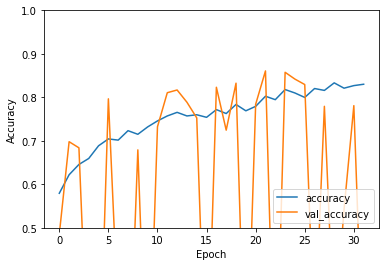

In [19]:
# Plot results
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [20]:
# Predict validation data
val_y_pred = np.argmax(model.predict(valX), axis=1)
print("Validation set prediction:")
print(confusion_matrix(val_y, val_y_pred, labels=[0, 1, 2]))
print(classification_report(val_y, val_y_pred, digits=3))

# Predict test data
test_y_pred = np.argmax(model.predict(testX), axis=1)
print("Test set prediction:")
print(confusion_matrix(test_y, test_y_pred, labels=[0, 1, 2]))
print(classification_report(test_y, test_y_pred, digits=3))

Validation set prediction:
[[309   7   3]
 [ 64 219   5]
 [  4   6  22]]
              precision    recall  f1-score   support

           0      0.820     0.969     0.888       319
           1      0.944     0.760     0.842       288
           2      0.733     0.688     0.710        32

    accuracy                          0.861       639
   macro avg      0.832     0.806     0.813       639
weighted avg      0.871     0.861     0.858       639

Test set prediction:
[[98  2  0]
 [19 81  0]
 [ 7  9 15]]
              precision    recall  f1-score   support

           0      0.790     0.980     0.875       100
           1      0.880     0.810     0.844       100
           2      1.000     0.484     0.652        31

    accuracy                          0.840       231
   macro avg      0.890     0.758     0.790       231
weighted avg      0.857     0.840     0.832       231

